In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
# from read_fk_table import get_fk_table
from read_faserv_pdf import read_pdf
# from read_LHEF import read_LHEF_data
from data_errors import compute_errors
from MC_data_reps import generate_MC_replicas
from postfit_criteria import Postfit
from form_loss_fct import complete_loss_fct, raw_loss_fct
from postfit_measures import Measures
from logspace_grid import generate_grid
# from rebin_fk_data import rebin_fk
from read_data_with_fk import read_LHEF_data, get_fk_table

In [2]:
# Define global variables
num_obs = 1 #between 1 and 4
REPLICAS  = 1

#HYPERPARAMETERS
preproc = 1


fit_level = 2
# lr = 1e-3

max_counter = 100
max_Nepochs = 3500

In [3]:
data, data_min, data_max, xvals_per_obs, binwidths, xlabels, events_per_obs = (
        read_LHEF_data()
    )
x_alphas, fk_tables = get_fk_table()


In [4]:

#Get errors
sig_sys,sig_tot, cov_matrix = compute_errors(data,data_min,data_max)    

#Generate MC replicas of data
sig_stat = np.sqrt(data)
level0,level1,level2 = generate_MC_replicas(REPLICAS,data,sig_sys,sig_stat)
# Get faserv pdf
pdf = "faserv"
lowx = -8
n=250
x_vals = generate_grid(lowx,n)
faser_pdf,x_faser = read_pdf(pdf,x_alphas.flatten(),12)

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


In [5]:
if fit_level ==0:
    pred = level0
if fit_level ==1:
    pred = level1
if fit_level ==2:
    pred = level2

/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_67019/1261818935.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)


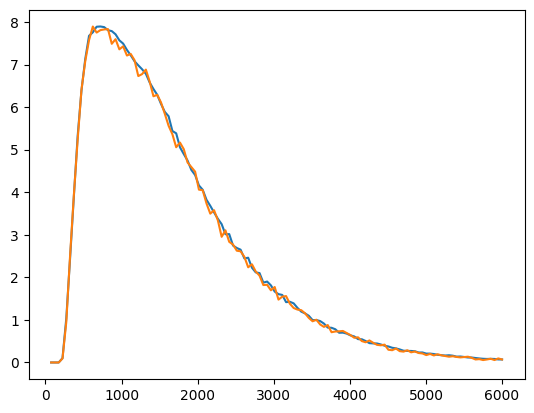

In [6]:
faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
conv = torch.matmul(fk_tables,faser_pdf) * binwidths 
plt.plot(xvals_per_obs,conv)
plt.plot(xvals_per_obs,data)

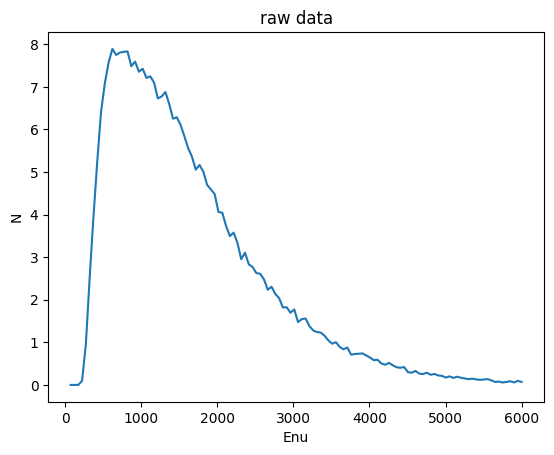

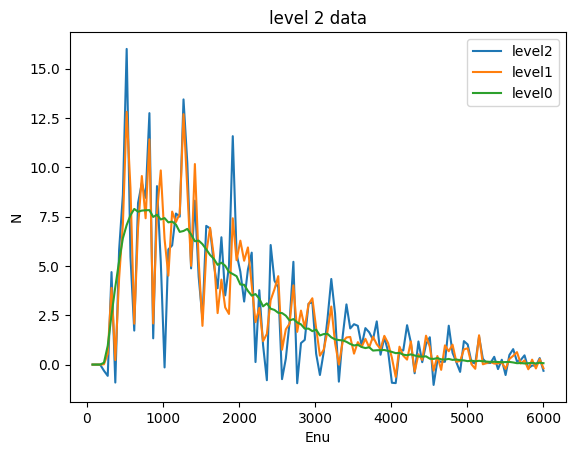

In [7]:
plt.plot(xvals_per_obs,events_per_obs)
plt.xlabel(xlabels)
plt.ylabel('N')
plt.title("raw data")
plt.show()

plt.plot(
    xvals_per_obs, level2[0], label="level2"
)
plt.plot(
    xvals_per_obs, level1[0], label="level1"
)
plt.plot(xvals_per_obs, events_per_obs,label="level0")
plt.xlabel(xlabels)
plt.legend()
plt.ylabel("N")
plt.title("level 2 data")
plt.show()


In [8]:
l1 = 20
l2 = 30
l3 = 20

class SimplePerceptron(torch.nn.Module):
    def __init__(self, l1,l2,l3):
        super(SimplePerceptron, self).__init__()
        self.linear = torch.nn.Linear(1,l1)
        self.hidden = torch.nn.Linear(l1,l2)
        self.hidden2 = torch.nn.Linear(l2,l3)
        self.hidden3 = torch.nn.Linear(l3,1)
        self.relu = torch.nn.ReLU()

    def forward(self, y):
        y = self.linear(y)
        y = self.relu(y)
        y = self.hidden(y)
        y = self.relu(y)
        y = self.hidden2(y)
        y = self.relu(y)
        y = self.hidden3(y)
        y = self.relu(y)
        # y = torch.nn.functional.softplus(y)
    
        return y

In [9]:
import torch.nn as nn


        
if preproc == 1:
    class CustomPreprocessing(nn.Module):
        def __init__(self, alpha,beta,gamma):
            super(CustomPreprocessing, self).__init__()

            # self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
            # self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32, requires_grad=True))
            # self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32, requires_grad=True))
            self.register_buffer("alpha", torch.tensor(alpha, dtype=torch.float32))
            self.register_buffer("beta", torch.tensor(beta, dtype=torch.float32))
            self.register_buffer("gamma", torch.tensor(gamma, dtype=torch.float32))


        def forward(self, x):
            # return self.gamma*(1 - x) ** abs(self.beta) * x ** (1-self.alpha)
            # alpha = (0.8*torch.tanh(self.alpha))
            # alpha = (0.8 - 0.2)/2 *torch.tanh(self.alpha) + (0.8+ 0.2)/2
            # beta = (1.9 - 0.1)/2 *torch.tanh(self.alpha) + (1.9 + 0.1)/2
            # beta = abs(self.beta)
            # return self.gamma * (1 - x) ** beta * x**(1-alpha) 
            # alpha = 1 - torch.nn.functional.softplus(self.alpha)
            # beta = torch.nn.functional.softmax(self.beta)
            return  self.gamma*(1 - x) ** self.beta * x**(1-self.alpha) 
            # return  (1 - x) * x 
        
    class PreprocessedMLP(nn.Module):
        def __init__(self, alpha, beta, gamma,l1, l2, l3):
            super(PreprocessedMLP, self).__init__()
            self.preprocessing = CustomPreprocessing(alpha, beta,gamma)
            self.mlp = SimplePerceptron(l1, l2, l3)

        def forward(self, x):
            f_preproc = self.preprocessing(x)
            f_NN = self.mlp(x)
            f_nu = f_preproc * f_NN
            return f_NN
        
        def neuralnet(self, x):
            f_NN = self.mlp(x)
            return f_NN
        
        def preproc(self, x):
            f_preproc = self.preprocessing(x)
            return f_preproc
        


In [10]:
# def raw_loss_fct(pred, data, cov_matrix, point1):
#     lag_mult = 0.1
#     diff = pred - data
#     # loss = (1 / pred.size(0)) * torch.sum(diff**2) + torch.sum(abs(last_point)) * 0.0
#     diffcov = torch.matmul(cov_matrix, diff)
#     # loss = (1 / pred.size(0)) * torch.dot(diff.view(-1), diffcov.view(-1))
#     # print(point1)
#     # print(point2)

#     # print(target.shape)
#     # print(point1.shape)
#     # print(point2.shape)
#     # print(diff[5])
#     # model = model.flatten()
#     # print((model * point2).shape)
#     # print((torch.sum((model * point2) ** 2) * 10).shape)
#     # print(model.shape)
#     # print(point1.shape)
#     # print((model * point2) ** 2)
#     # print(torch.sum((model * point2) ** 2) * 10)
#     loss = (
#         torch.dot(diff.view(-1), diffcov.view(-1))
#     )
#     return loss
#     # if loss < 5:

In [11]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()

    def forward(self,pred,
    data,
    cov_matrix, network_params,x_int1,x_int2
    ):
        loss = raw_loss_fct(pred,
    data,
    cov_matrix, network_params,x_int1,x_int2)
        return loss

In [12]:
#Define variables for fit
# x_alpha_more_bins = np.logspace(-5,0,250)
# x_alpha_more_bins = torch.tensor(x_alpha_more_bins, dtype=torch.float32).view(-1,1)
# lowx = -8
# n=250
x_vals = generate_grid(lowx,n)
x_vals = torch.tensor(x_vals, dtype=torch.float32).view(-1,1)
# x_vals = x_alphas
neutrino_pdfs,N_event_pred, arc_lenghts, chi_squares, int_penaltys,pos_penaltys, preproc_pdfs, nn_pdfs  = [],[],[],[],[],[],[],[]

In [13]:
lr = 0.001
def perform_fit(pred,REPLICAS):
    for i in range(REPLICAS):
        losses = []
        if preproc == 1:
            alpha,beta,gamma = 1,1,10
            model = PreprocessedMLP(alpha, beta, gamma,l1, l2, l3)


        criterion = CustomLoss()
        # criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=0.1)
        # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        # optimizer = torch.optim.SGD(model.parameters(), lr=lr,momentum=.9)
        pred[i] = pred[i].squeeze()

        model.train()

        best_loss = 1e13 # initial loss
        counter = 0
        # num_epochs = 200

        # dataset_size = data.shape[0]
        # validation_split = 0  # 20% validation
        # indices = np.arange(dataset_size)
        # np.random.shuffle(indices)  # Shuffle indices randomly
        # val_size = int(dataset_size * validation_split)
        # train_indices, val_indices = indices[val_size:], indices[:val_size]
        # pred_t = pred[i][train_indices]
        # cov_matrix_train = cov_matrix[train_indices][:, train_indices]

        nbatch = 30
        num_epochs = 0
        # for ep in range(num_epochs):
        #     shuffle = np.random.permutation(len(xvals_per_obs))
        while counter < max_counter:  
        #     if num_epochs>max_Nepochs:
        #         break
            
            num_epochs+=1
            
            # last_point = model(x_vals).squeeze()[-1]
            # for j in range(len(xvals_per_obs)//nbatch):
            optimizer.zero_grad()
            y_pred =  model(x_alphas) 
            # print(y_pred[-1])
            y_preds = torch.matmul(fk_tables,y_pred) * binwidths 
            y_preds = y_preds.squeeze()


            # y_shuffle = y_preds[shuffle]
            # pred_shuffle = pred[i][shuffle]
            # cov_matrix_shuffle = cov_matrix[shuffle][:, shuffle]


            # y_batch = y_shuffle[j*nbatch:(j+1)*nbatch]
            # pred_batch = pred_shuffle[j*nbatch:(j+1)*nbatch]

            # cov_matrix_batch = cov_matrix_shuffle[j * nbatch:(j + 1) * nbatch, j * nbatch:(j + 1) * nbatch]
            

            # integrability_points = model(x_vals)[0]
            integrability_points = 0.
            # print(integrability_points)
            x_int1 = torch.tensor([1.], dtype=torch.float32).view(-1,1)
            loss= criterion(y_preds, pred[i],cov_matrix, integrability_points,x_int1,x_int1)
            print(loss)
    
            # losses.append(loss.detach().numpy())
            loss.backward()
            optimizer.step()

            if loss < best_loss:
                best_loss = loss
                counter = 0
            else:
                counter +=1  

        
        # if ep % 100 == 0:
        #     print(loss)
            # cov_matrix_val = cov_matrix[val_indices][:, val_indices]
            # y_val = y_preds[val_indices]
            # pred_val = pred[i][val_indices]
            # loss_val = criterion(y_val, pred_val, cov_matrix_val,network_params)
            # print(f'loss val = {loss_val}')

        # print(loss.detach().numpy())   
        if loss <.00001:
            break
        # if loss < best_loss:
        #     best_loss = loss
        #     counter = 0
        # else:
        #     counter +=1   

        if loss < 600:    
            print(num_epochs) 
        
            print(f"Constrained alpha: {(model.preprocessing.alpha.item())}")
            print(f"Constrained beta: {(model.preprocessing.beta.item())}")
            # print(f"Constrained gamma: {model.preprocessing.gamma.item()}") 


            # closure_fit = Postfit()
            # arc_lenghts.append(closure_fit.compute_arc_length(model))
            # chi_squares.append(loss.detach().numpy())

            f_nu = model(x_vals).detach().numpy().flatten() 

            preproc_pdfs.append(model.preproc(x_vals).detach().numpy().flatten())
            nn_pdfs.append(model.neuralnet(x_vals).detach().numpy().flatten())

            N_event_pred.append(y_preds.detach().numpy())
            plt.rcParams.update(
                {
                    "font.family": "serif",
                    "font.serif": ["cmr10"],  # Computer Modern
                }
            )
            plt.grid(color="grey", linestyle="-", linewidth=0.25)
            plt.plot(xvals_per_obs,y_preds.detach().numpy().flatten(),label = r"$\mathrm{NN}(x_\nu)$")
            plt.plot(xvals_per_obs,pred[i],label = 'Level 2 simulated data')
            plt.xlabel(r"$E_\nu$")
            plt.ylabel(r"$\mathrm{N}_{\mathrm{int}}$")
            plt.legend()
            plt.savefig('no_wd_events.pdf')
            plt.show()
            

            plt.plot(x_vals,f_nu,label='mu')
            plt.xlabel(r"$f_{\nu_\mu}(x_\nu)$")
            plt.ylabel(r"$\mathrm{N}_{\mathrm{int}}$")
            plt.xscale('log')
            plt.yscale('log')
            plt.ylim(10**-3,10**4)
            plt.legend()
            plt.savefig('wd_flux.pdf')
            plt.show()
            

            neutrino_pdfs.append(f_nu)
            plt.yscale('log')
            print(f'counter = {counter}')
            plt.plot(range(1, len(losses) + 1), losses)
            plt.xlabel('#epochs')
            plt.ylabel('loss')
            plt.title('level 0 closure test, no preprocessing')
            plt.show()
            # plt.plot(x_alpha_more_bins,preproc_pdf)
            # plt.xscale('log')
            # plt.yscale('log')
            # plt.show()
    return arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model

tensor(532.8999, grad_fn=<AddBackward0>)
tensor(532.8348, grad_fn=<AddBackward0>)
tensor(532.7714, grad_fn=<AddBackward0>)
tensor(532.7121, grad_fn=<AddBackward0>)
tensor(532.6570, grad_fn=<AddBackward0>)
tensor(532.6049, grad_fn=<AddBackward0>)
tensor(532.5548, grad_fn=<AddBackward0>)
tensor(532.5080, grad_fn=<AddBackward0>)
tensor(532.4629, grad_fn=<AddBackward0>)
tensor(532.4190, grad_fn=<AddBackward0>)
tensor(532.3761, grad_fn=<AddBackward0>)
tensor(532.3335, grad_fn=<AddBackward0>)
tensor(532.2910, grad_fn=<AddBackward0>)
tensor(532.2485, grad_fn=<AddBackward0>)
tensor(532.2058, grad_fn=<AddBackward0>)
tensor(532.1636, grad_fn=<AddBackward0>)
tensor(532.1221, grad_fn=<AddBackward0>)
tensor(532.0818, grad_fn=<AddBackward0>)
tensor(532.0422, grad_fn=<AddBackward0>)
tensor(532.0032, grad_fn=<AddBackward0>)
tensor(531.9640, grad_fn=<AddBackward0>)
tensor(531.9248, grad_fn=<AddBackward0>)
tensor(531.8856, grad_fn=<AddBackward0>)
tensor(531.8466, grad_fn=<AddBackward0>)
tensor(531.8073,

/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_67019/2195929899.py:121: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.grid(color="grey", linestyle="-", linewidth=0.25)


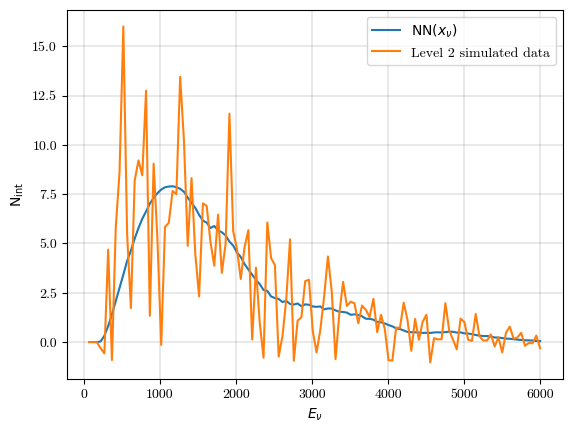

/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_67019/2195929899.py:131: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(x_vals,f_nu,label='mu')


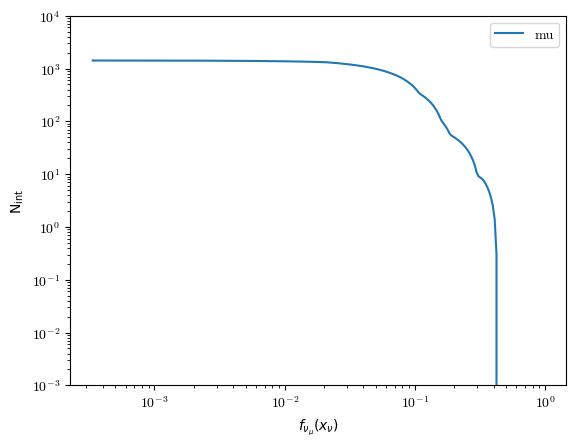

counter = 100


/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_67019/2195929899.py:143: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.yscale('log')
/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


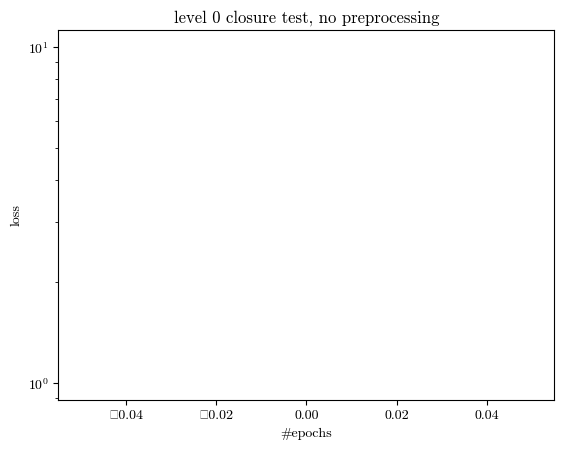

In [14]:
arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(pred,REPLICAS)

In [15]:
closure_fit = Postfit()
neutrino_pdfs, N_event_pred = closure_fit.apply_postfit_criteria(chi_squares,N_event_pred,neutrino_pdfs)

/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [16]:
# x_vals = x_vals.detach().numpy().flatten()
x_vals = x_vals.detach().numpy().flatten()
faser_pdf,x_faser = read_pdf(pdf,x_vals,12) 
mean_fnu = np.mean(neutrino_pdfs,axis=0) *x_vals

mean_pdf_preproc = np.mean(preproc_pdfs,axis=0) 
mean_nn_pdf = np.mean(nn_pdfs,axis=0) 

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


In [17]:
# from lhapdf_grid import write_lhapdf_grid
# mean_fnu = np.mean(neutrino_pdfs, axis=0) * x_vals
# lhapdfpath = '/opt/anaconda3/envs/nnpdf_dev/share/LHAPDF/enu/enu_0000.dat'

# write_lhapdf_grid(x_vals,mean_fnu,lhapdfpath)

/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_67019/676687337.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(x_vals,mean_fnu/x_vals,'o',label="fnu",markersize=1.5)


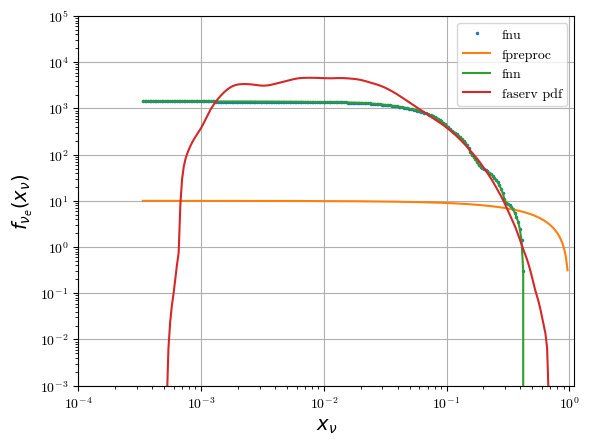

In [18]:
# plt.plot(cont_x,mean_pdf_preproc*mean_nn_pdf*(x_alpha_more_bins.detach().numpy().flatten()),label = 'mult' )
plt.plot(x_vals,mean_fnu/x_vals,'o',label="fnu",markersize=1.5)
plt.plot(x_vals,mean_pdf_preproc,label="fpreproc",markersize=1.5)
plt.plot(x_vals,mean_nn_pdf,label="fnn",markersize=1.5)
# plt.axvline(x=min(xvals_per_obs[0])/14000, color='green', linestyle='--', label='no data to the left of this line')
plt.plot(x_faser,faser_pdf,label ='faserv pdf')
plt.xlabel(r"$x_{\nu}$",fontsize = 14)
plt.ylabel(r"$f_{\nu_e}(x_{\nu})$",fontsize = 14)
plt.ylim(10**-3,10**5)
plt.xlim(10**-4,1.1)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

[0.         0.         0.         0.094313   0.95331377 2.511322
 3.9368002  5.237868   6.4064956  7.077459   7.572754   7.8927727
 7.75098    7.80799    7.824366   7.8325167  7.4868326  7.5953283
 7.357482   7.4273243  7.2117515  7.2492795  7.102587   6.7287354
 6.7750134  6.8806114  6.5993648  6.2542324  6.287479   6.107839
 5.8423715  5.5604157  5.362529   5.0568295  5.1661353  5.011607
 4.6987815  4.5914545  4.482641   4.060857   4.046506   3.736136
 3.4965472  3.5765986  3.3397493  2.9522798  3.1048992  2.8340125
 2.7707844  2.625337   2.6122084  2.4814348  2.236677   2.3067994
 2.1363928  2.0395815  1.8192859  1.824655   1.695446   1.7725506
 1.4771693  1.5468084  1.5598941  1.3811095  1.2799484  1.2428153
 1.228947   1.155658   1.0464622  0.96802026 1.0040203  0.8923118
 0.8366782  0.87928396 0.71099293 0.7277107  0.73217386 0.7403091
 0.6914975  0.64268595 0.58031553 0.59140724 0.50237155 0.47457796
 0.5174227  0.46194145 0.4143409  0.4036336  0.41897133 0.29945454
 0.2881532  

/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:34: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  axL = fig.add_subplot(gs[0, 0])
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:35: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  axR = fig.add_subplot(gs[0, 1])
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:36: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  axrL = fig.add_subplot(gs[1, 0])
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:37: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  axrR = fig.add_subplot(gs[1, 1])
/Users/jukkajohn/Masterscriptie/faser_nufluxes

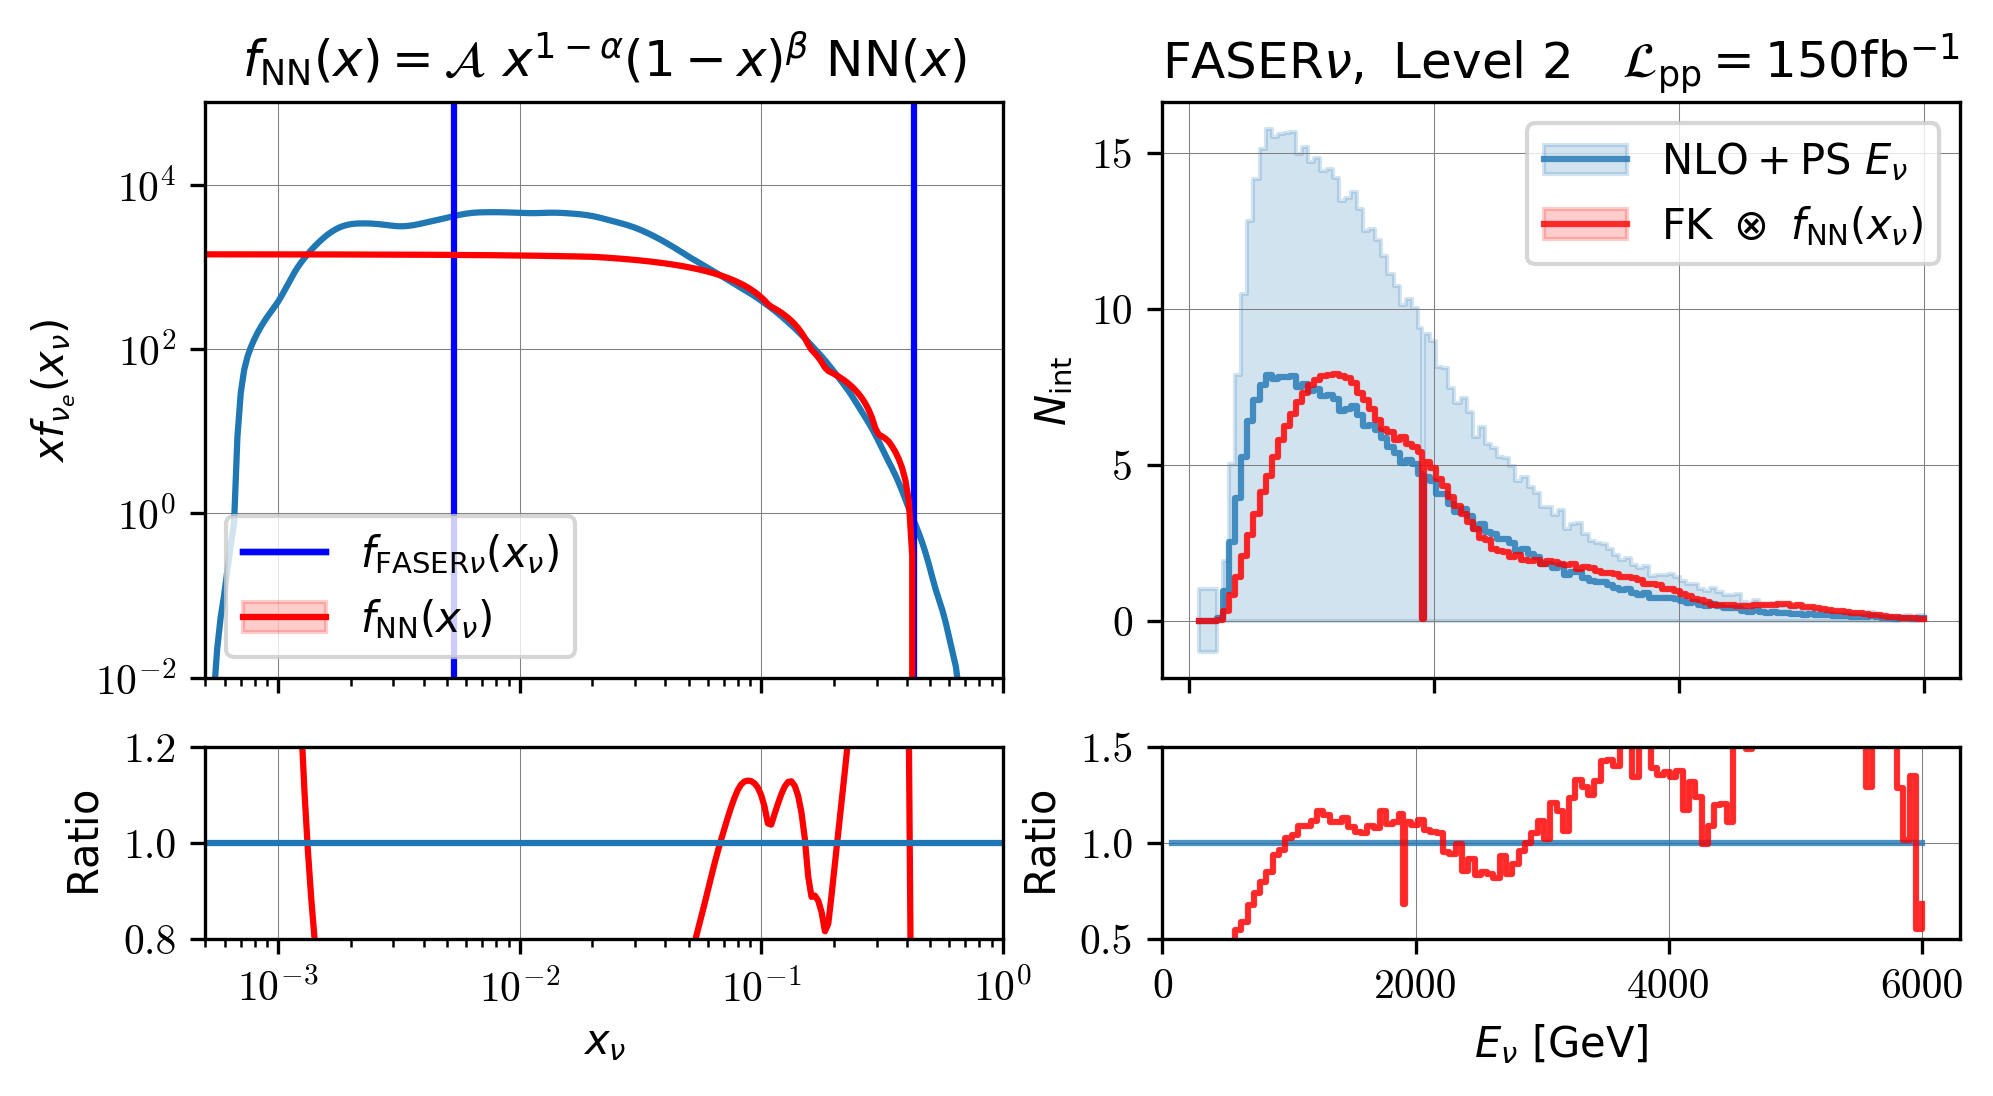

In [19]:
from plot_results import plot
plot(x_vals, neutrino_pdfs, level0, N_event_pred, sig_tot, xvals_per_obs,12)

/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_67019/3347743561.py:6: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(xvals_per_obs,mean_N_event_fit,label="Level 0 closure test")


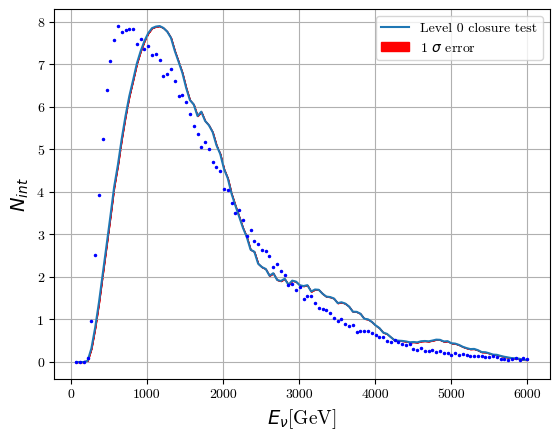

In [20]:
mean_N_event_fits = np.mean(N_event_pred,axis=0)
sigma_N_event_fits = np.std(N_event_pred,axis=0)

mean_N_event_fit = mean_N_event_fits.flatten()
sigma_N_event_fit = sigma_N_event_fits.flatten()
plt.plot(xvals_per_obs,mean_N_event_fit,label="Level 0 closure test")

plt.fill_between(xvals_per_obs,(mean_N_event_fit+sigma_N_event_fit),(mean_N_event_fit-sigma_N_event_fit),label=r"1 $\sigma$ error",color = 'red')

# plt.plot(xvals_per_obs[i],events_per_obs[i],'go',markersize=1.5)
plt.plot(xvals_per_obs,level0[0],'bo',markersize=1.5)
# plt.errorbar(xvals_per_obs[i],events_per_obs[i],yerr=np.sqrt(sig_tot),label='POWHEG +PY8 NLO',color = 'green',alpha=0.6 )
# plt.fill_between(xvals_per_obs[i],events_per_obs[i]+np.sqrt(sig_tot), events_per_obs[i]-np.sqrt(sig_tot),color = 'green',alpha=0.6)
plt.xlabel(r"$E_{\nu}$[GeV]",fontsize = 14)
plt.ylabel(r"$N_{int}$",fontsize = 14)
plt.grid()
plt.legend()
# plt.savefig('N_int_fit.pdf')
plt.show()
    

In [21]:
# Quantitative validation of PDF uncertainties in closure tests
# theoretical prediction for # of events
pdf = "faserv"
lowx = -8
n=50
# x_vals = generate_grid(lowx,n)

faser_pdf,x_faser = read_pdf(pdf,x_vals)
postfit_measures = Measures(cov_matrix, pdf, N_event_pred)
delta_chi = postfit_measures.compute_delta_chi(num_obs, fk_tables, binwidths, level1[0],x_vals)
print(f'delta chi^2 = {delta_chi}')

phi_chi_squared = postfit_measures.compute_phi(data, chi_squares)
print(f'phi level 2 = {phi_chi_squared}')

dist,xnu  = postfit_measures.compute_distance(neutrino_pdfs,x_vals)
plt.plot(xnu,dist,'o')
plt.ylabel('distance to truth')
plt.xlabel('xnu')
plt.show()

TypeError: read_pdf() missing 1 required positional argument: 'particle'

In [ ]:
def compute_accuracy():
    log_spaced = np.logspace(np.log10(1e-5), np.log10(0.1), 10)
    linear_spaced = np.linspace(0.1, 1, 10)
    x_xi_measure = np.concatenate((log_spaced, linear_spaced))
    x_xi_measure= torch.tensor(x_xi_measure, dtype=torch.float32).view(-1,1)

    pdf = "faserv"

    faser_pdf,x_faser = read_pdf(pdf,x_xi_measure)
    faser_pdf =faser_pdf.detach().numpy().squeeze()

    arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level1,REPLICAS=  1)
    mean_neutrino_pdf =model(x_xi_measure).detach().numpy().squeeze()
    
    return mean_neutrino_pdf,faser_pdf,n

# mean_neutrino_pdf,faser_pdf,n = compute_accuracy()
# xi = np.sum(abs(mean_neutrino_pdf-faser_pdf) < error_neutrino_fit)/ n
# print(f'xi = {xi}')

In [ ]:
def compute_bias_to_variance(num_level1_shifts,level0,level1,level2):
    biases = []
    variances = []
    level1 = np.array(level1)
    level0 = np.array(level0)
    diff_level01 = level1 - level0
    level2 -= diff_level01
    level0 = torch.tensor(level0, dtype=torch.float32)
    for i in range(num_level1_shifts):
        
        # generate level2 data with different level 1 shifts
        r_sys = np.random.normal(0, 1) * sig_sys / 10
        r_stat = np.random.normal(0, 1) * np.sqrt(data) / 10
        level2 += r_sys + r_stat
        level2 = torch.tensor(level2, dtype=torch.float32)
        
        arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level2,REPLICAS = 3)
        mean_N_events = np.mean(N_event_pred,axis=0)
        mean_N_events = torch.tensor(mean_N_events, dtype=torch.float32)
        
        mean_chi_square = raw_loss_fct(level0[0],mean_N_events,cov_matrix)
        biases.append(mean_chi_square)

        chi_square_level2 = 0
        for j in range (REPLICAS):
            chi_square_level2 += raw_loss_fct(level2[j],mean_N_events, cov_matrix)
        variances.append(chi_square_level2/REPLICAS)


    exp_bias = np.mean(biases)
    exp_variance = np.mean(variances)
    ratio = exp_bias/exp_variance
    return ratio
    
# ratio = compute_bias_to_variance(1,level0,level1,level2)
# print(f'ratio = {ratio}')


#BIAS:
    # mc reps = level 1 + level 2
    # average over level 1: keep level 2 the same, but add different level 1 shifts
    # compute reduced chi square with respect to level 0 data
    # VARIANCE:
    # mc reps = level 1 + level 2
    # average chi^2 over several level 2 shifts
    # do not average over level 1 shifts since it is expected to be constant
    # Compute reduced chi square with respect to all level 2 replics: so do not have to run a lot more fits it seems
    # however since these multiple level 1 fits have to be run anyway, it is no problemo